Here’s a proposed workflow:

- Use the arXiv API to pull daily papers.
- Generate metadata such as publication date, update date, authors, research lab, etc.
- Index the data on LlamaCloud.
- Repeat steps 1-3 on a daily basis.
- Create an outline for the report. (Ideally from user)
- Develop a report-generating agent.
- Generate report based on the outline.

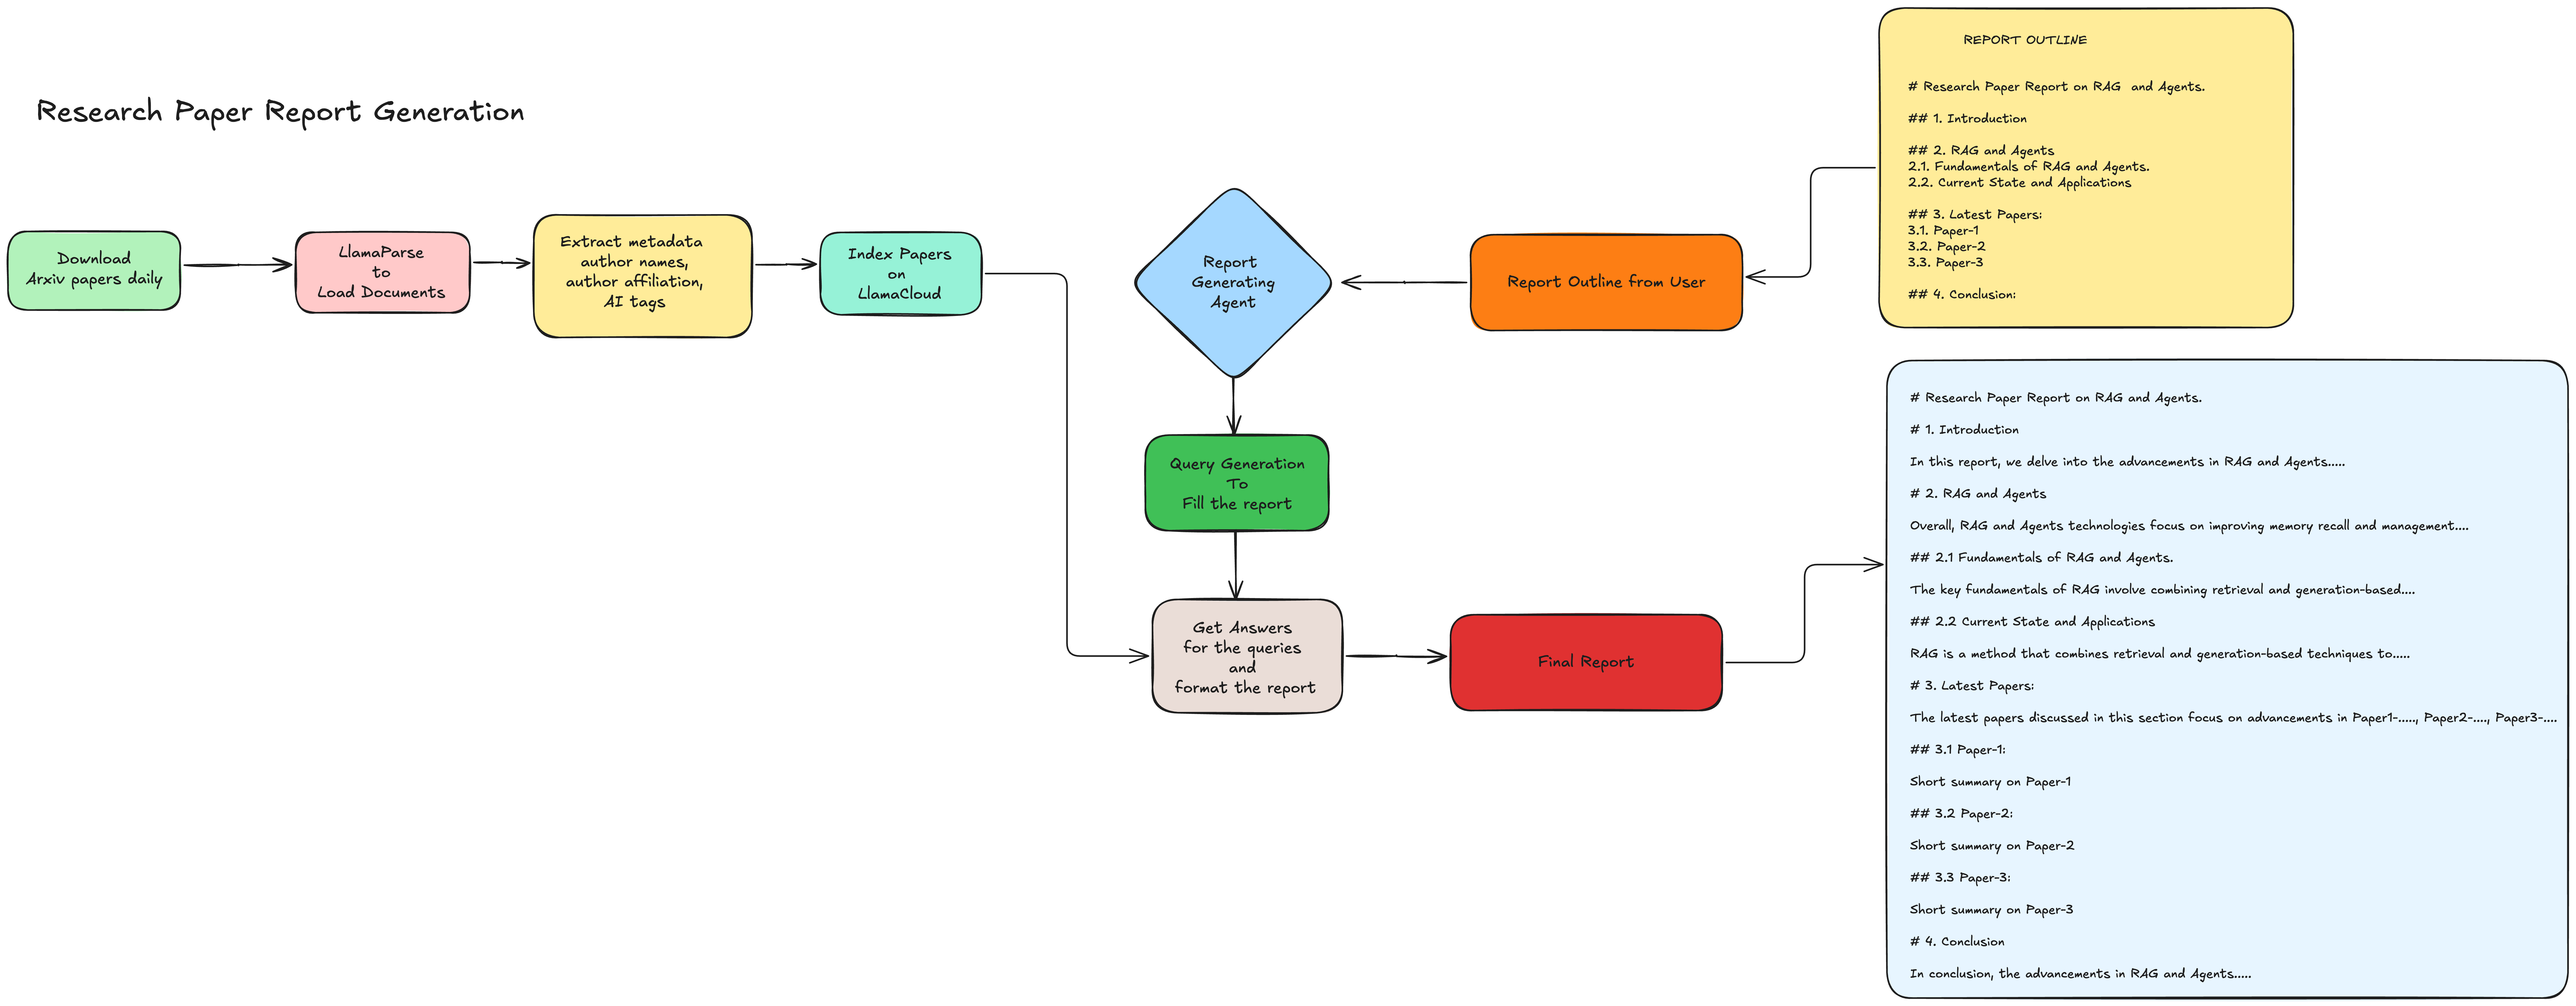

### Installation
We'll be utilizing various packages along with LlamaIndex:

- LlamaCloud - For creating a managed index in the cloud.
- LlamaParse - For effective document parsing.
- arxiv - For accessing the latest research papers.

In [1]:

%pip install -q -U llama-index llama-index-indices-managed-llama-cloud llama-parse llama-cloud arxiv



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# The nest_asyncio library is used to allow nested asynchronous event loops.
import nest_asyncio

nest_asyncio.apply()

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LLAMA_CLOUD_API_KEY"] = os.getenv("LLAMA_CLOUD_API_KEY")

In [4]:
from llama_index.llms.openai import OpenAI
llm = OpenAI(model="gpt-4o-mini")


### Download arxiv papers based on topics.


In [ ]:
research_paper_topics = ["RAG","AI Agent"]

In [6]:
import arxiv
from pathlib import Path
os.makedirs("papers", exist_ok=True)

def download_papers(client, topics, num_results_per_topic):
    for topic in topics:
        search = arxiv.Search(
            query=topic,
            max_results=num_results_per_topic,
            sort_by=arxiv.SortCriterion.SubmittedDate,
        )
        results = client.results(search)
        for r in results:
            r.download_pdf(Path("papers"))

def list_pdf_files(directory):
    pdf_files = [directory+"/"+file.name for file in Path(directory).glob("*.pdf")]
    return pdf_files

In [7]:
client = arxiv.Client()
download_papers(client, research_paper_topics, 2)

In [8]:
print(list_pdf_files("papers"))

['papers/2411.18615v1.Proactive_Gradient_Conflict_Mitigation_in_Multi_Task_Learning__A_Sparse_Training_Perspective.pdf', 'papers/2411.18583v1.Automated_Literature_Review_Using_NLP_Techniques_and_LLM_Based_Retrieval_Augmented_Generation.pdf', 'papers/2411.18216v1.Evaluating_and_Improving_the_Robustness_of_Security_Attack_Detectors_Generated_by_LLMs.pdf', 'papers/2411.18612v1.Robust_Offline_Reinforcement_Learning_with_Linearly_Structured__f__Divergence_Regularization.pdf']


We downloaded research papers for each topics

### Parse docuements using LlamaParse

In [10]:
from llama_parse import LlamaParse

def parse_pdf(pdf_files):
    llama_parse = LlamaParse(
        result_type="markdown",
        num_workers=4,  # if multiple files passed, split in `num_workers` API calls
        verbose=True,
    )
    documents = []
    
    for i, pdf_file in enumerate(pdf_files):
        print(f"Processing {i+1/len(pdf_files)}: ", {pdf_file})
        document = llama_parse.load_data(pdf_file)
        documents.append(document)
    return documents

In [11]:
documents = parse_pdf(list_pdf_files("papers"))

Processing 0.25:  {'papers/2411.18615v1.Proactive_Gradient_Conflict_Mitigation_in_Multi_Task_Learning__A_Sparse_Training_Perspective.pdf'}
Started parsing the file under job_id e04af4ea-57f9-49e9-9b9b-99f8c6b352ce
..Processing 1.25:  {'papers/2411.18583v1.Automated_Literature_Review_Using_NLP_Techniques_and_LLM_Based_Retrieval_Augmented_Generation.pdf'}
Started parsing the file under job_id d1210b50-238b-4f4f-97a9-3a36daae3166
Processing 2.25:  {'papers/2411.18216v1.Evaluating_and_Improving_the_Robustness_of_Security_Attack_Detectors_Generated_by_LLMs.pdf'}
Started parsing the file under job_id 199f4da9-e67f-44a6-9cff-56dfc9ed5fa0
Processing 3.25:  {'papers/2411.18612v1.Robust_Offline_Reinforcement_Learning_with_Linearly_Structured__f__Divergence_Regularization.pdf'}
Started parsing the file under job_id 985a436b-4c87-4f2b-9f47-b1a203307129
.

In [12]:
len(documents)

4

In [13]:
for doc in documents[0]:
    print(doc.text)

# Proactive Gradient Conflict Mitigation in Multi-Task Learning: A Sparse Training Perspective

Zhi Zhang1, Jiayi Shen1, Congfeng Cao1, Gaole Dai2, Shiji Zhou3, Qizhe Zhang2, Shanghang Zhang2* Ekaterina Shutova1*

1ILLC, University of Amsterdam, Netherlands

2State Key Laboratory of Multimedia Information Processing, School of Computer Science, Peking University, China

3Department of Automation, Tsinghua University, China

zhangzhizz2626@gmail.com, j.shen@uva.nl, shanghang@pku.edu.cn, e.shutova@uva.nl

# Abstract

Advancing towards generalist agents necessitates the concurrent processing of multiple tasks using a unified model, thereby underscoring the growing significance of simultaneous model training on multiple downstream tasks. A common issue in multi-task learning is the occurrence of gradient conflict, which leads to potential competition among different tasks during joint training. This competition often results in improvements in one task at the expense of deterioration in an

### Utils
Here, we define some utilities to help us extract metadata from each document, create a LlamaCloud pipeline/index, and upload the documents to the pipeline/index.

- Metadata - Pydantic model to extract metadata of author names, companies and general AI tags.
- get_papers_metadata - Extracts the metadata information from the research paper.
- create_llamacloud_pipeline - Create LlamaCloud pipeline.
- upload_documents - Upload the research papers to LlamaCloud index.

In [16]:
from llama_cloud.types import CloudDocumentCreate
from pydantic import BaseModel,Field
from typing import List 
from llama_cloud.client import LlamaCloud
from llama_index.core.prompts import PromptTemplate
from llama_index.core.async_utils import run_jobs

In [17]:
class Metadata(BaseModel):
    author_names : List[str] = Field(...,description="List of author names of the paper. Give empty list if not available.")
    author_companies : List[str] = Field(...,description="List of author companies of the paper. Give empty list if not available.")
    ai_tags : List[str] = Field(...,description="List of AI tags of the paper. Give empty list if not available.")

def create_llamacloud_pipeline(pipeline_name, embedding_config,transform_config,data_sink_id=None):
    client = LlamaCloud(token=os.environ['LLAMA_CLOUD_API_KEY'])
    pipeline = {
        "name": pipeline_name,
        "embedding_config" : embedding_config,
        "transform_config" : transform_config,
        "data_sink_id": data_sink_id
    }
    pipeline = client.pipelines.upsert_pipeline(request=pipeline)
    return client, pipeline

async def get_papers_metadata(text):
    prompt_template = PromptTemplate("""Generate authors names, authors companies, and general top 3 AI tags for the given research paper.

    Research Paper:

    {text}""")
    
    metadata = await llm.astructured_predict(
        Metadata,
        prompt_template,
        text=text,
    )
    return metadata

async def get_document_upload(document,llm):
    text_for_metadata = document[0].text+document[1].text+document[2].text
    metadata = await get_papers_metadata(text_for_metadata)
    full_text = "\n\n".join([doc.text for doc in document])
    
    cloud_document = CloudDocumentCreate(
        text = full_text,
        metadata= {
            "author_names": metadata.author_names,
            "author_companies": metadata.author_companies,
            "ai_tags": metadata.ai_tags
        }
    )
    return cloud_document


async def upload_documents(documents):
    extract_jobs = []
    for document in documents:
        extract_jobs.append(get_document_upload(document,llm))
    document_upload_objs = await run_jobs(extract_jobs,workers=4)
    _ = client.pipelines.create_batch_pipeline_documents(pipeline.id,request=document_upload_objs)
    

### Create LlamaCloud pipeline.
We will first create a LlamaCloud pipeline (empty index) before uploading documents. We need embedding_config and transform_config for the same.

embedding_config - This config provides details about the embedding model and the corresponding API key used for creating embeddings during the indexing stage. Here we use OpenAI embeddings.

transform_config - This config outlines the chunk_size and chunk_overlap parameters used during the indexing stage

In [18]:
# Embedding config
embedding_config = {
    'type': 'OPENAI_EMBEDDING',
    'component': {
        'api_key': os.environ["OPENAI_API_KEY"], # editable
        'model_name': 'text-embedding-ada-002' # editable
    }
}

# Transformation auto config
transform_config = {
    'mode': 'auto',
    'config': {
        'chunk_size': 1024,
        'chunk_overlap': 20
    }
}


client,pipeline = create_llamacloud_pipeline("report_generation",embedding_config, transform_config)

### Upload documents to LlamaCloud index.
Now that we have set up a pipeline (an empty index), we will upload the downloaded documents using the specified embedding_config and transform_config configurations.

In [19]:
await upload_documents(documents)

### Create Index and QueryEngine

Let's connect to the created LlamaCloud index and build a QueryEngine to use it for report generation.

We will utilize hybrid search combined with re-ranking (cohere-reranker) for this purpose.

In [20]:
from llama_index.indices.managed.llama_cloud import LlamaCloudIndex

# Connects to a pre-built index in the Llama Cloud platform.
index = LlamaCloudIndex(
          name="report_generation",
          project_name="Default",
          api_key=os.environ['LLAMA_CLOUD_API_KEY'])

query_engine = index.as_query_engine( #Configures a query engine to search the index.
  dense_similarity_top_k=10, #Top k results based on dense (vector) similarity.
  sparse_similarity_top_k=10, #Top k results based on sparse (keyword-based) similarity.
  alpha=0.5,# Balances dense and sparse results (0 = only sparse, 1 = only dense).
  enable_reranking=True, #Reranks results to improve relevance.
  rerank_top_n = 5,#Number of top results to rerank
  retrieval_mode="chunks" #retrieves text in smaller units (e.g., paragraphs).
)

Utils to create queries for generating report based on outline.
Sample Outline of the Report

```markdown
START OF OUTLINE OF THE REPORT
Research Paper Report on RAG - Retrieval Augmented Generation and Agentic World.

1. Introduction

2. Retrieval Augmented Generation (RAG) and Agents
2.1. Fundamentals of RAG and Agents.
2.2. Current State and Applications

3. Latest Papers:
3.1. Paper-1 title (to be filled).
3.2. Paper-2 title (to be filled).
3.3. Paper-3 title (to be filled).

4. Conclusion:
```

END OF OUTLINE OF THE REPORT

Here is a sample outline for the report we intend to generate. We need to populate sections like Introduction, Retrieval Augmented Generation (RAG) and Agents, and its sub-sections Fundamentals of RAG and Agents, Current State and Applications, and Latest Papers, as well as the final Conclusion. This can be done either by using an LLM or the LlamaCloud Index.

To complete these sections, we'll need to query the index/LLM for relevant information. We will craft queries based on the sub-sections and sections within the context of the report's title. Here are some utilities to assist in this task.

- extract_title: Function to extract the title from the first line of the outline.

- generate_query_with_llm: Function to generate a query for a report using LLM.

- classify_query: Function to classify the query as either 'LLM' or 'INDEX' based on the query content.

- parse_outline_and_generate_queries: Function to parse the outline and generate queries for each section and subsection.

**NOTE** : The utilities should be adjusted based on the specific outline of the report we are considering. This ensures that they align with the sections and sub-sections we need to populate.

In [21]:
import re
def extract_title(outline):
    first_line = outline.strip().split("\n")[0]
    return first_line.strip("# ").strip()

    
def generate_query_with_llm(title,section, subsection):
    prompt = f"Generate a research query for a report on {title}. "
    prompt += f"The query should be for the subsection '{subsection}' under the main section '{section}'. "
    prompt += "The query should guide the research to gather relevant information for this part of the report. The query should be clear, short and concise. "
    
    response = llm.complete(prompt)

    return str(response).strip()

def classify_query(query):
    """Function to classify the query as either 'LLM' or 'INDEX' based on the query content"""

    prompt = f"""Classify the following query as either "LLM" if it can be answered directly by a large language model with general knowledge, or "INDEX" if it likely requires querying an external index or database for specific or up-to-date information.

    Query: "{query}"

    Consider the following:
    1. If the query asks for general knowledge, concepts, or explanations, classify as "LLM".
    2. If the query asks for specific facts, recent events, or detailed information that might not be in the LLM's training data, classify as "INDEX".
    3. If unsure, err on the side of "INDEX".

    Classification:"""
    
    classification = str(llm.complete(prompt)).strip().upper()
    if classification not in ["LLM", "INDEX"]:
        classification = "INDEX"
    return classification

def parse_outline_and_generate_queries(outline):
    lines = outline.strip().split("\n")
    title = extract_title(outline)
    current_section = ""
    queries = {}
    
    for line in lines[1:]:
        if line.startswith("## "):
            current_section = line.strip("# ").strip()
            queries[current_section] = {}
            
        elif re.match(r'^\d+\.\d+\.', line):
            subsection = line.strip()
            query = generate_query_with_llm(title,current_section, subsection)
            classification = classify_query(query)
            queries[current_section][subsection] = {"query":query, "classification":classification}
    
    #handle the sections without subsections
    for section in queries:
        if not queries[section]:
            query = generate_query_with_llm(title,section, "General Overview")
            queries[section]['General'] = {"query":query, "classification":"LLM"}
    
    return queries  
            
            


In [22]:
outline = """
# Research Paper Report on RAG - Retrieval Augmented Generation and Agentic World.

## 1. Introduction

## 2. Retrieval Augmented Generation (RAG) and Agents
2.1. Fundamentals of RAG and Agents.
2.2. Current State and Applications

## 3. Literature Review

## 4. Latest Papers and Recent Advancements:
4.1. Towards Context-Rich Automated Biodiversity Assessments: Deriving AI-Powered Insights from Camera Trap Data
4.2. MULTI-AGENT ENVIRONMENTS FOR VEHICLE ROUTING PROBLEMS
4.3. Insight-V: Exploring Long-Chain Visual Reasoning with Multimodal Large Language Models

## 5. Conclusion:
"""

In [23]:
queries = parse_outline_and_generate_queries(outline)

In [24]:
queries

{'1. Introduction': {'General': {'query': '**Research Query for General Overview:**\n\n"Provide a comprehensive overview of Retrieval Augmented Generation (RAG) and its implications in the context of agentic worlds. Include definitions, key components, and the significance of RAG in enhancing information retrieval and generation processes. Discuss its applications, potential benefits, and challenges within agentic environments."',
   'classification': 'LLM'}},
 '2. Retrieval Augmented Generation (RAG) and Agents': {'2.1. Fundamentals of RAG and Agents.': {'query': '**Research Query for Subsection 2.1: Fundamentals of RAG and Agents**\n\n"Investigate the foundational concepts of Retrieval Augmented Generation (RAG) and its integration with agent-based systems. Focus on the mechanisms of RAG, including its architecture, data retrieval processes, and generation techniques. Additionally, explore the role of agents in enhancing RAG capabilities, their functionalities, and how they interact 

# Report Generation AGENT

#### Here we create an agent to generate the final report based on the outline.

Following are the steps following in generating the report.

- Generates queries to fill the report from the outline.

- Generates answers for the queries using LlamaCloud index.

- Fill back the answers to relevant parts in the report.

- Format the final report.

In [25]:
from typing import List, Any, Dict
import os

from llama_index.core.llms.function_calling import FunctionCallingLLM

In [26]:
class ReportGenerationReport:
    def __init__(self,query_engine: Any, llm: FunctionCallingLLM):
        self.query_engine = query_engine
        self.llm = llm
    
    
    def parse_outline_and_generate_queries(self,outline):
        lines = outline.strip().split("\n")
        title = extract_title(outline)
        current_section = ""
        queries = {}
        
        for line in lines[1:]:
            if line.startswith("## "):
                current_section = line.strip("# ").strip()
                queries[current_section] = {}
                
            elif re.match(r'^\d+\.\d+\.', line):
                subsection = line.strip()
                query = generate_query_with_llm(title,current_section, subsection)
                classification = classify_query(query)
                queries[current_section][subsection] = {"query":query, "classification":classification}
        
        #handle the sections without subsections
        for section in queries:
            if not queries[section]:
                query = generate_query_with_llm(title,section, "General Overview")
                queries[section]['General'] = {"query":query, "classification":"LLM"}
        
        return queries  
    
    def generate_section_content(self,queries):
        sections_content = {}
        for section, subsections in queries.items():
            sections_content[section] = {}
            subsection_keys = subsections.keys()
            for subsection in subsection_keys:
                data = subsections[subsection]
                query = data['query']
                classification = data['classification']
                if classification == "LLM":
                    answer = str(self.llm.complete(query+"Give a short answer."))
                else:
                    answer = str(self.query_engine.query(query))
                sections_content[section][subsection] = answer
        return sections_content
    
    def format_report(self,sections_content, outline):
        report = ""
        
        for section, subsections in sections_content.items():
            section_match = re.match(r'^(\d+\.)\s*(.*)$', section)
            if section_match:
                section_num, section_title = section_match.groups()
                if "introduction" in section.lower():
                    introduction_num, introduction_title = section_num, section_title
                elif "conclusion" in section.lower():
                    conclusion_num, conclusion_title = section_num, section_title
                else:
                    combined_content = ("\n").join(subsections.values())
                    summary_query = f"Provide a short summary for section '{section}': \n\n {combined_content}"
                    section_summary = str(self.llm.complete(summary_query))
                    report += f"# {section_num} {section_title}\n\n {section_summary}\n\n"
                    
                    report = self.get_subsection_content(subsections,report)
                    
        # add introduction and conclusion
        introduction_query = f"Create an introduction for the report:\n\n{report}"
        introduction = str(self.llm.complete(introduction_query))
        report = f"# {introduction_num} {introduction_title}\n\n{introduction}\n\n" + report
        
        conclusion_query = f"Create a conclusion for the report:\n\n{report}"
        conclusion = str(self.llm.complete(conclusion_query))
        report += f"# {conclusion_num} {conclusion_title}\n\n{conclusion}\n\n"
        
        # add title
        title = extract_title(outline)
        report = f"# {title}\n\n{report}"
        return report


    def get_subsection_content(self, subsections,report):
        for subsection in sorted(subsections.keys(), key=lambda x: re.search(r'(\d+\.\d+)', x).group(1) if re.search(r'(\d+\.\d+)', x) else x):
            content = subsections[subsection]
            subsection_match = re.search(r'(\d+\.\d+)\.\s*(.+)', subsection)
            if subsection_match:
                subsection_num, subsection_title = subsection_match.groups()
                report += f"## {subsection_num} {subsection_title}\n\n{content}\n\n"
            else:
                report += f"## {subsection}\n\n{content}\n\n"
        return report
    
    async def run_workflow(self,outline):
        queries = self.parse_outline_and_generate_queries(outline)
        sections_content = self.generate_section_content(queries)
        report = self.format_report(sections_content, outline)
        return report
            

In [27]:
import asyncio

agent = ReportGenerationReport(query_engine, llm)
report = asyncio.run(agent.run_workflow(outline))
print(report)

# Research Paper Report on RAG - Retrieval Augmented Generation and Agentic World.

# 1. Introduction

# Introduction

In the rapidly evolving landscape of artificial intelligence, the integration of Retrieval-Augmented Generation (RAG) with agent-based systems represents a significant advancement in enhancing the capabilities of Large Language Models (LLMs). RAG serves as a bridge between generative models and external knowledge bases, allowing AI systems to access a broader spectrum of information and improve the accuracy and relevance of their outputs. By mitigating issues such as hallucinations and factual inaccuracies, RAG not only enhances the quality of responses generated by AI but also empowers agents to make more informed decisions in complex environments.

This report delves into the fundamentals of RAG and its application within agentic frameworks, exploring how this innovative approach transforms the interaction between AI systems and users. The first section provides a co

In [28]:
with open("report_markdown.md", "w") as f:
    f.write(report)

# ROUGH

In [ ]:
# queries

{'1. Introduction': {'General': {'query': '**Research Query for General Overview:**\n\n"Provide a comprehensive overview of Retrieval Augmented Generation (RAG) and its implications in the context of agentic worlds. Include definitions, key components, and the significance of RAG in enhancing information retrieval and generation processes. Discuss its applications, potential benefits, and challenges in various domains."',
   'classification': 'LLM'}},
 '2. Retrieval Augmented Generation (RAG) and Agents': {'2.1. Fundamentals of RAG and Agents.': {'query': '**Research Query for Subsection 2.1: Fundamentals of RAG and Agents**\n\n"Investigate the core principles and mechanisms of Retrieval Augmented Generation (RAG) and its integration with agent-based systems. Focus on the architecture of RAG, the role of retrieval in enhancing generative models, and the characteristics of agentic systems that utilize RAG. Include key definitions, theoretical frameworks, and examples of applications in 

In [ ]:
def generate_section_content(queries):
        sections_content = {}
        for section, subsections in queries.items():
            sections_content[section] = {}
            subsection_keys = subsections.keys()
            for subsection in subsection_keys:
                data = subsections[subsection]
                query = data['query']
                classification = data['classification']
                if classification == "LLM":
                    answer = str(llm.complete(query+"Give a short answer."))
                else:
                    answer = str(query_engine.query(query))
                sections_content[section][subsection] = answer
        return sections_content

In [ ]:
content = generate_section_content(queries)

In [ ]:
content

{'1. Introduction': {'General': 'Retrieval Augmented Generation (RAG) is a hybrid approach that combines information retrieval with generative models to enhance the quality and relevance of generated content. It typically involves two key components: a retriever, which fetches relevant documents or data from a knowledge base, and a generator, which synthesizes this information into coherent responses.\n\n**Significance:** RAG improves the accuracy and contextuality of generated outputs by grounding them in real-world data, making it particularly valuable in agentic worlds—environments where autonomous agents interact and make decisions based on dynamic information.\n\n**Applications:** RAG is utilized in various domains, including customer support, content creation, education, and healthcare, where it can provide accurate, contextually relevant information quickly.\n\n**Benefits:** The approach enhances information retrieval by ensuring that generated content is not only relevant but a

In [ ]:
query_engine.query("Tell me the recent advancements in multiagent AI")

Response(response='The recent advancements in multiagent AI include equipping models with robust capabilities across diverse domains, emphasizing fine-grained detail analysis and localization in visual understanding, and training models to generate step-by-step reasoning for mathematics and expert-level tasks. Additionally, there is a focus on structured reasoning paths, extended reasoning chains, and the implementation of multi-agent systems to decompose and enhance complex reasoning processes, ultimately enhancing the overall reasoning capabilities of existing models.', source_nodes=[NodeWithScore(node=TextNode(id_='814e8432-7593-4132-a480-5c529d4e0ce6', embedding=None, metadata={'author_names': ['Yuhao Dong', 'Zuyan Liu', 'Hai-Long Sun', 'Jingkang Yang', 'Winston Hu', 'Yongming Rao', 'Ziwei Liu'], 'author_companies': ['NTU', 'Tencent', 'Tsinghua University', 'Nanjing University'], 'ai_tags': ['Multimodal Learning', 'Visual Reasoning', 'Large Language Models'], 'pipeline_id': 'be4358

In [ ]:
section = "4. Latest Papers and Recent Advancements"
section_match = re.match(r'^(\d+\.)\s*(.*)$', section)

('4.', 'Latest Papers and Recent Advancements')